In [5]:
# Imports
import re
import pathlib
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from cycler import cycler
# plt.rcParams["axes.prop_cycle"] = cycler(color='bgrcmyk')

# Define some useful function

def load_data(results_file, check_error=True):
    """Load and preprocess data"""
    df = pd.read_csv(results_file, sep="\t")
    # Separate out benchmark command
    warp_command = df.iloc[-1].idx
    df = df.iloc[:-1]
    # Drop some unused columns
    df = df.drop(['idx'], axis=1)
    if check_error:
        if df.error.isna().all():
            df = df.drop('error', axis=1)
        else:
            raise Exception("Errors found in df.error column")
    if df.n_objects.eq(1).all():
        df = df.drop('n_objects', axis=1)
    # Convert some data dtypes
    for col in ['start', 'end']:
        # df[col] = df[col].map(dt.datetime.fromisoformat)
        df[col] = df[col].map(lambda x: dt.datetime.strptime(x.split('.')[0], '%Y-%m-%dT%H:%M:%S'))
    
    return df, warp_command

def load_summary(filename):
    df = pd.read_csv(filename, sep="\t")
    df = df[~(df.op == "op")]
    for col in ['mb_per_sec', 'objs_per_sec']:
        df[col] = pd.to_numeric(df[col])
    return df

def parse_text_summary(filename):
    """Parses the text summary from `warp analyze ...` and generates a dict of throughput values"""
    # Read input and compile reusable regexs
    op_regex = re.compile(r"[A-Z][A-Z]+")
    score_regex = re.compile(r"[0-9]+\.[0-9]+\ [a-zA-Z]+/s")
    with open(filename, "r") as file:
        lines = file.readlines()
    # Iterate through file lines and extract relevant pieces
    scores = {}
    current_op = None
    for line in lines:
        if line.startswith("Operation: "):
            op = op_regex.search(line)[0]
            current_op = op
            scores[op] = {}
        elif line.startswith(" * Throughput: "):
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores[current_op][unit_type + "_per_sec"] = float(val)
        elif line.startswith("Cluster Total: "):
            scores["Total"] = {}
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores["Total"][unit_type + "_per_sec"] = float(val)

    return scores

def make_bins(df, N_bins):
    """Selects bin edges for data based on log scale and"""
    data = df.bytes[df.op == "PUT"] / 1024**2
    min_size = round(data.min(), ndigits=4)
    max_size = round(data.max())
    return 10**np.linspace(np.log10(min_size), np.log10(max_size), N_bins+1)

def make_filesize_histogram(df, ax, N_bins=10):
    """Plots a histogram showing the distribution of file sizes in the benchmark data"""
    bins = make_bins(df, N_bins)
    data = df.bytes[df.op == "PUT"] / 1024**2
    ax.hist(data, bins=bins, histtype="bar", ec="black")
    ax.set_title("Distribution of randomized file sizes in benchmark data")
    ax.set_xlabel("File size (MiB)")
    ax.set_ylabel("File count")
    ax.set_xscale('log')
    return ax

def make_timings_plot(df, ax, op, N_bins=20):
    
    """Plots file size vs operation time info for benchmark data"""
    
    allowed_ops = df.op.unique()
    if op not in allowed_ops:
        raise Exception("op must be one of", allowed_ops)
    
    bins = make_bins(df, N_bins)
    df = df[df.op == op].copy()
    df['bytes_bin'] = np.digitize(df.bytes / 1024**2, bins)

    data = df.drop('thread', axis=1).groupby('bytes_bin').mean(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Avg")

    data = df.drop('thread', axis=1).groupby('bytes_bin').min(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Min")

    data = df.drop('thread', axis=1).groupby('bytes_bin').max(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Max")

    ax.set_title(f"Reponse times for {op} operations")
    ax.set_xlabel('File size (MiB)')
    ax.set_xscale('log')
    ax.set_ylabel('Operation time (secs)')
    ax.set_yscale('log')
    ax.legend()
    

def plot_grouped_bars(scores, unit, ax=None, op_colours=None):
    groups = list(scores.keys())
    ops = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {op:[scores[g][op][unit] for g in groups] for op in ops}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(ops)) # the width of the bars
    # multiplier = -1
    multiplier = (1.5 - len(ops)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    for i, (op, score) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            score, 
            width, 
            ec="k", 
            label=op, 
            zorder=3,
            color=(op_colours[op] if op_colours is not None else None)
        )
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(unit.replace("_per_sec", "/s"))
    ax.set_xticks(x + width, groups)
    ax.legend(ncols=3, title="Operation:")
    
    return ax

In [53]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-10-100-1100-1KiB-5GiB-10m.csv.zst")
df

,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
0,372.0,GET,zm82xY,1.670300e+04,http://172.26.70.68,fbNJudV4/1.YzgMQhIryrNSOzul.rnd,2023-03-04 10:26:30,2023-03-04T10:26:30.604037668Z,2023-03-04 10:26:30,1.098906e+07
1,389.0,STAT,zm82xY,0.000000e+00,http://172.26.70.68,OUoL4Ip3/1.5w8XpzNEy1mo(V10.rnd,2023-03-04 10:26:30,NaN,2023-03-04 10:26:30,4.024189e+06
2,312.0,DELETE,zm82xY,0.000000e+00,http://172.26.70.68,D5HPVN09/1.jVVv4efG3iggCrF(.rnd,2023-03-04 10:26:30,NaN,2023-03-04 10:26:30,1.557335e+07
3,314.0,DELETE,zm82xY,0.000000e+00,http://172.26.70.68,K27)4W8a/1.vBL9U1I2V2ut1One.rnd,2023-03-04 10:26:30,NaN,2023-03-04 10:26:30,2.333158e+08
4,324.0,GET,zm82xY,8.698088e+06,http://172.26.70.68,4G6KHKAe/1.JyeF((4EivzmcBRQ.rnd,2023-03-04 10:26:30,2023-03-04T10:26:30.622851632Z,2023-03-04 10:26:31,6.619020e+08
...,...,...,...,...,...,...,...,...,...,...
56335,650.0,PUT,W9Fo09,1.104000e+03,http://172.26.70.68,fHNxq9kI/8.RIY)STn(a(eSYpE1.rnd,2023-03-04 10:36:30,NaN,2023-03-04 10:36:30,3.595984e+08
56336,325.0,GET,zm82xY,2.177921e+09,http://172.26.70.68,(4QnZhJn/2.lilmaWwvjbfakhUq.rnd,2023-03-04 10:36:30,2023-03-04T10:36:30.699188594Z,2023-03-04 10:39:15,1.654239e+11
56337,640.0,STAT,W9Fo09,0.000000e+00,http://172.26.70.68,uo2Zuh)p/7.ADOvdkxfgcrtry43.rnd,2023-03-04 10:36:30,NaN,2023-03-04 10:36:30,2.561988e+07
56338,293.0,DELETE,ttObZA,0.000000e+00,http://172.26.70.68,b151huwS/8.7ZwV3py2rrXrLfCy.rnd,2023-03-04 10:36:30,NaN,2023-03-04 10:36:30,1.162775e+08


In [84]:
def naive_throughput(df, op, bin_size=60):
    data = df.copy()
    data = data[data.op == op]
    timestamps = data.end.map(lambda dt: dt.timestamp())
    bins = np.arange(timestamps.min(), timestamps.max(), bin_size)
    data['time_bin'] = np.digitize(timestamps, bins)
    data = (data.groupby(['time_bin'])['bytes'].sum() / 1024**2) / bin_size
    return data

# df, cmd = load_data("benchmark-runs/warp-results-full.mixed-1-1-1000-1KiB-5GiB-30m.csv.zst")
# df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
# X = [5, 10, 15, 20, 30, 60, 100, 120]
# Y = [naive_throughput(df, "GET", bin_size=b).mean() for b in X]
# plt.scatter(X, Y)

In [103]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
# df[df.op == "GET"].groupby('thread')[['bytes', 'duration_ns']].sum()
df['MiB/s'] = (df.bytes / 1024**2) / (df.duration_ns / 10**9)
df[df.op == "GET"].groupby('thread')['MiB/s'].mean().sum()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_56271/1839841783.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


4463.268021871801

In [27]:
def calculate_throughputs(df, operation, unit, bin_size=10, verbose=False):
    """ 
    Follows the analsis procedure described in the `warp` docs at
    https://github.com/minio/warp#analysis-data
    to calculate throughputs from benchmark results
    """
    data = df.copy() # Don't mutate input
    t_start = data.groupby('thread').end.first().max()
    t_end = data.groupby('thread').start.last().min()
    data = data[(data.start > t_start) & (data.end < t_end)]
    data = data[data.op == operation].iloc[1:-1]
    if verbose:
        print("Analysis window:", data.end.max() - data.start.min())
        print("Analysis start time:", data.start.min())
        print("Items in window:", len(data))
        print("Average number of bytes:", data.bytes.mean().astype(int))
    
    timestamps = data.end.map(lambda dt: dt.timestamp())
    bins = np.arange(t_start.timestamp(), t_end.timestamp(), bin_size)
    data['time_bin'] = np.digitize(timestamps, bins)
    data = data.groupby(['time_bin', 'thread'])

    if unit == "MiB":
        data = data['bytes'].sum()
        throughputs = data.groupby('time_bin').sum() / (1024**2 * bin_size)
    elif unit == "objs":
        throughputs = data.file.unique().map(len).groupby('time_bin').sum() / bin_size
    else:
        raise Exception("`unit` must be one of:", ["MiB", "objs"])
        
    if verbose:
        print("Average throughout:", throughputs.mean(), f"{unit}/second\n")

    return throughputs

# df, cmd = load_data("benchmark-runs/warp-results-full.mixed-1-1-1000-1KiB-5GiB-30m.csv.zst")
# df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
# for op in df.op.unique():
#     print(op)
#     print(calculate_throughputs(df, op, "MiB", bin_size=5, verbose=False).describe())

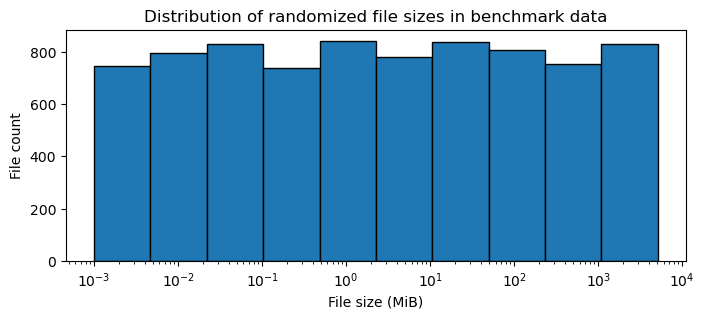

In [13]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-10-100-1100-1KiB-5GiB-10m.csv.zst")
fig, ax = plt.subplots(figsize=(8, 3))
make_filesize_histogram(df, ax)
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_56271/1839841783.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


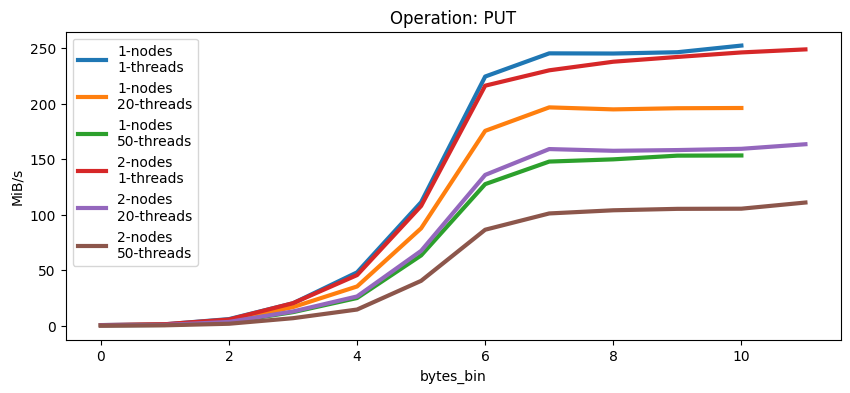

In [174]:
op = "PUT"
fig, ax = plt.subplots(figsize=(10, 4))
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    df, _ = load_data(f'benchmark-runs/warp-results-full.mixed-{nodes}-{threads}-1000-1KiB-5GiB-30m.csv.zst')
    bins = make_bins(df, 10)
    df = df[df.op == op]
    df['bytes_bin'] = np.digitize(df.bytes / 1024**2, bins)
    df['MiB/s'] = (df.bytes / 1024**2) / (df.duration_ns / 1e9)
    df.groupby(['bytes_bin'])['MiB/s'].mean().plot(ax=ax, label=key, lw=3)

ax.set_ylabel('MiB/s')
ax.set_title("Operation: "+op)
ax.legend()
plt.show()

In [196]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-1-20-1000-1KiB-5GiB-30m.csv.zst")

df

,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns,obj/s
0,17.0,STAT,d5fP2t,0.000000e+00,http://172.26.70.68,SjQfzCtc/23.7CXUcIvvDsJeAJkN.rnd,2023-03-02 18:55:49.366684+00:00,NaN,2023-03-02 18:55:49.368287+00:00,1.603203e+06,623.751328
1,16.0,GET,d5fP2t,7.268589e+07,http://172.26.70.68,EK4CA7hL/10.kqu48OCILcZ4NJTp.rnd,2023-03-02 18:55:49.366705+00:00,2023-03-02T18:55:49.372245295Z,2023-03-02 18:55:49.705574+00:00,3.388690e+08,2.950993
2,10.0,GET,d5fP2t,9.285000e+03,http://172.26.70.68,0aPloKyA/40.vV7rgvCWDV0hLJv2.rnd,2023-03-02 18:55:49.366727+00:00,2023-03-02T18:55:49.368994037Z,2023-03-02 18:55:49.369093+00:00,2.365405e+06,422.760584
3,6.0,GET,d5fP2t,1.253162e+08,http://172.26.70.68,0aPloKyA/23.Uxzjq4LluEV8o16B.rnd,2023-03-02 18:55:49.366740+00:00,2023-03-02T18:55:49.373809008Z,2023-03-02 18:55:50.055462+00:00,6.887218e+08,1.451965
4,15.0,GET,d5fP2t,2.855670e+05,http://172.26.70.68,0aPloKyA/19.Q9vRYYe54NBAq8Qs.rnd,2023-03-02 18:55:49.366743+00:00,2023-03-02T18:55:49.36986556Z,2023-03-02 18:55:49.370518+00:00,3.774626e+06,264.926909
...,...,...,...,...,...,...,...,...,...,...,...
36063,11.0,PUT,d5fP2t,2.724985e+09,http://172.26.70.68,osk9o270/348.hOU)t)9Dhte1NynL.rnd,2023-03-02 19:25:49.315893+00:00,NaN,2023-03-02 19:26:01.506282+00:00,1.219039e+10,0.082032
36064,1.0,STAT,d5fP2t,0.000000e+00,http://172.26.70.68,9qUOAh2d/263.sXCD7faSRvOq8Jao.rnd,2023-03-02 19:25:49.354023+00:00,NaN,2023-03-02 19:25:49.354827+00:00,8.044630e+05,1243.065250
36065,1.0,STAT,d5fP2t,0.000000e+00,http://172.26.70.68,Anr4Wo78/185.J1SOA2lc1PRA1ORY.rnd,2023-03-02 19:25:49.354831+00:00,NaN,2023-03-02 19:25:49.355569+00:00,7.384820e+05,1354.129146
36066,1.0,PUT,d5fP2t,5.306770e+05,http://172.26.70.68,Tzwh(iLb/267.rYks8dyAhUFXzZQH.rnd,2023-03-02 19:25:49.355577+00:00,NaN,2023-03-02 19:25:49.365557+00:00,9.979368e+06,100.206747


/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_56271/1839841783.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


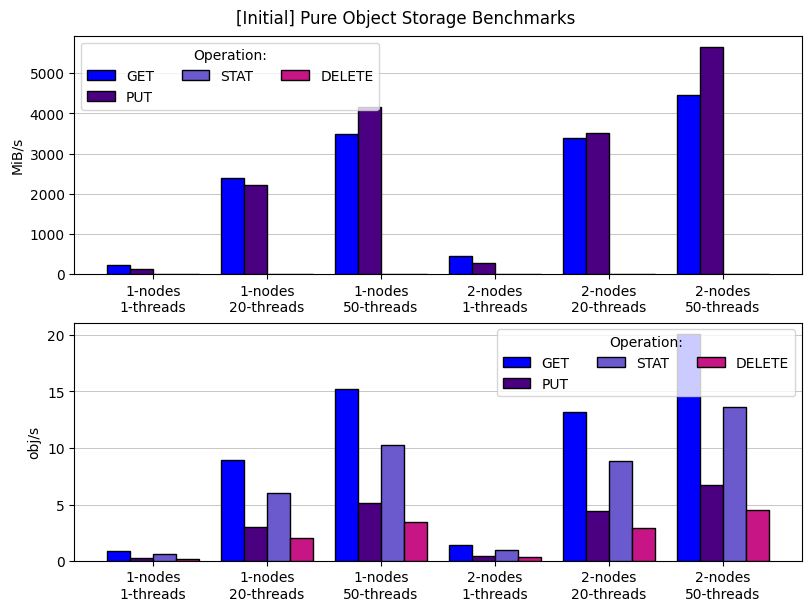

In [210]:
def naive_scores(df):
    df = df.copy()
    df["MiB/s"] = (df.bytes / 1024**2) / (df.duration_ns / 1e9)
    scores = {}
    for op in df.op.unique():
        data = df[df.op == op]
        scores[op] = {}
        scores[op]['MiB_per_sec'] = data.groupby('thread')['MiB/s'].mean().sum()
        scores[op]['obj_per_sec'] = data.file.count() / (data.end.max() - data.start.min()).seconds
        
    return scores
    
# df, cmd = load_data("benchmark-runs/warp-results-full.mixed-1-1-1000-1KiB-5GiB-30m.csv.zst")
# naive_scores(df)
# df["MiB/s"] = (df.bytes / 1024**2) / (df.duration_ns / 1e9)
# df.groupby('thread')['MiB/s'].mean().sum()
scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    df, cmd = load_data(f'benchmark-runs/warp-results-full.mixed-{nodes}-{threads}-1000-1KiB-5GiB-30m.csv.zst')
    scores[key] = naive_scores(df)

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
plt.savefig("initial-pure-results.png")
plt.show()

In [9]:
# summary_df = load_summary("benchmark-runs/warp-results-summary.mixed-1-1-1000-1KiB-5GiB-30m.csv")
summary_df = load_summary("benchmark-runs/warp-results-summary.mixed-2-50-1000-1KiB-5GiB-30m.csv")
summary_df.mb_per_sec[df.op == "GET"].mean()

1885.1650733950696

In [57]:
scores = {}
for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50, 100]):
    key = f"{nodes}-nodes\n{threads}-threads"
    df, _ = load_data(f'benchmark-runs/warp-results-full.mixed-{nodes}-{threads}-1100-1KiB-5GiB-10m.csv.zst')
    scores[key] = {}
    for op in df.op.unique():
        scores[key][op] = {}
        for unit in ['MiB', 'objs']:
            scores[key][op][unit + "_per_sec"] = round(calculate_throughputs(df, op, unit, bin_size=30).mean(), 2)
scores

/tmp/ipykernel_558/2046284749.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_bin'] = np.digitize(timestamps, bins)
/tmp/ipykernel_558/2046284749.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_bin'] = np.digitize(timestamps, bins)
/tmp/ipykernel_558/2046284749.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

{'1-nodes\n1-threads': {'GET': {'MiB_per_sec': 263.0, 'objs_per_sec': 0.68},
  'PUT': {'MiB_per_sec': 77.24, 'objs_per_sec': 0.23},
  'DELETE': {'MiB_per_sec': 0.0, 'objs_per_sec': 0.24},
  'STAT': {'MiB_per_sec': 0.0, 'objs_per_sec': 0.45}},
 '1-nodes\n20-threads': {'STAT': {'MiB_per_sec': 0.0, 'objs_per_sec': 6.45},
  'DELETE': {'MiB_per_sec': 0.0, 'objs_per_sec': 3.28},
  'GET': {'MiB_per_sec': 2463.5, 'objs_per_sec': 9.62},
  'PUT': {'MiB_per_sec': 1058.23, 'objs_per_sec': 3.26}},
 '1-nodes\n50-threads': {'GET': {'MiB_per_sec': 3842.58,
   'objs_per_sec': 14.22},
  'STAT': {'MiB_per_sec': 0.0, 'objs_per_sec': 9.57},
  'DELETE': {'MiB_per_sec': 0.0, 'objs_per_sec': 4.85},
  'PUT': {'MiB_per_sec': 1615.31, 'objs_per_sec': 4.82}},
 '1-nodes\n100-threads': {'STAT': {'MiB_per_sec': 0.0, 'objs_per_sec': 12.27},
  'GET': {'MiB_per_sec': 4169.92, 'objs_per_sec': 18.1},
  'DELETE': {'MiB_per_sec': 0.0, 'objs_per_sec': 6.18},
  'PUT': {'MiB_per_sec': 1946.73, 'objs_per_sec': 6.15}},
 '2-node

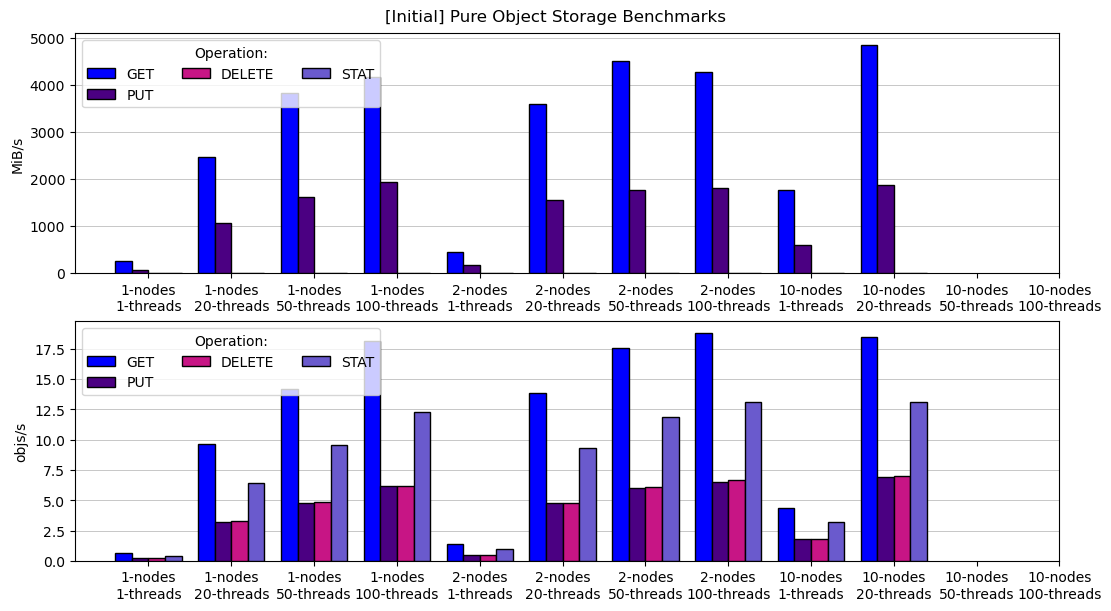

In [59]:
# Code 

# scores = {}
# for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50, 100]):
#     key = f"{nodes}-nodes\n{threads}-threads"
#     run_scores = parse_text_summary(f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1100-1KiB-5GiB-10m.txt')
#     for k, v in run_scores.items():
#         if v == {}:
#             run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
#     scores[key] = run_scores

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(11, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "objs_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
# plt.savefig("initial-pure-results.png")
plt.show()

In [ ]:
scores = {}
for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = parse_text_summary(f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1100-1KiB-5GiB-10m.txt')
scores

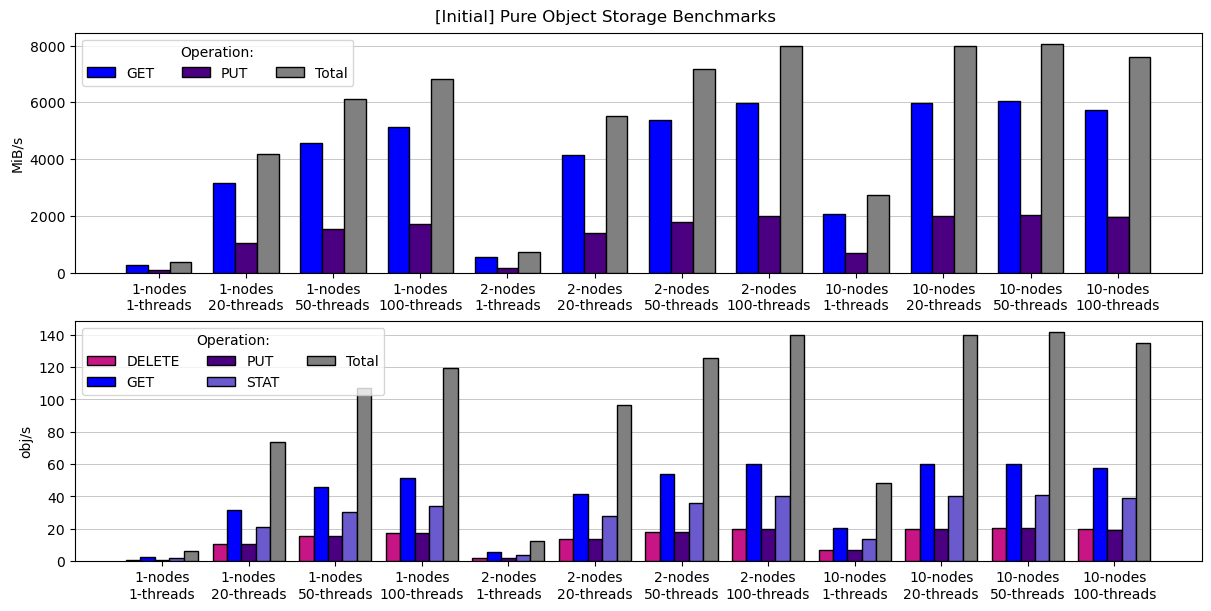

In [11]:
# Code 

scores = {}
for nodes, threads in itertools.product([1, 2, 10], [1, 20, 50, 100]):
    key = f"{nodes}-nodes\n{threads}-threads"
    run_scores = parse_text_summary(f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1100-100MiB-10m.txt')
    for k, v in run_scores.items():
        if v == {}:
            run_scores[k] = {"MiB_per_sec": 0, "obj_per_sec": 0}
    scores[key] = run_scores

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
# plt.savefig("initial-pure-results.png")
plt.show()

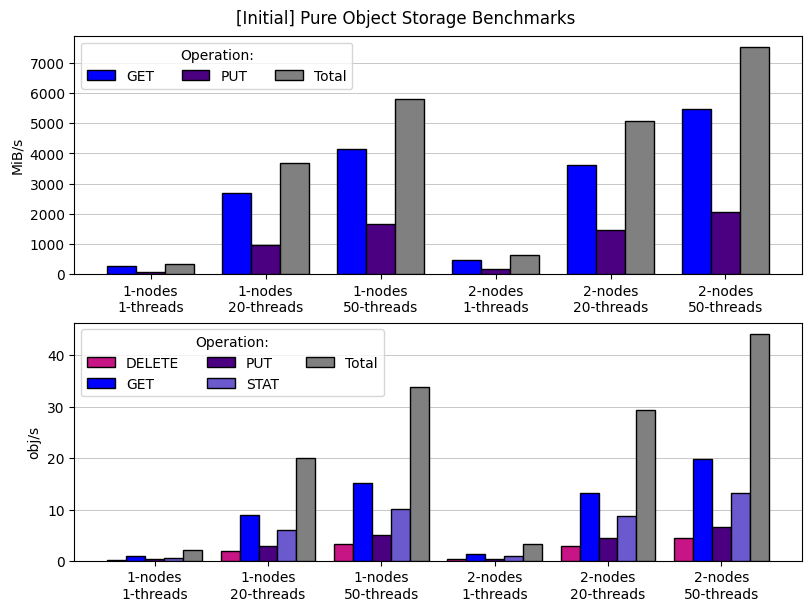

In [71]:
# Code 

scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = parse_text_summary(f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1000-1KiB-5GiB-30m.txt')

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
# plt.savefig("initial-pure-results.png")
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_56271/1839841783.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


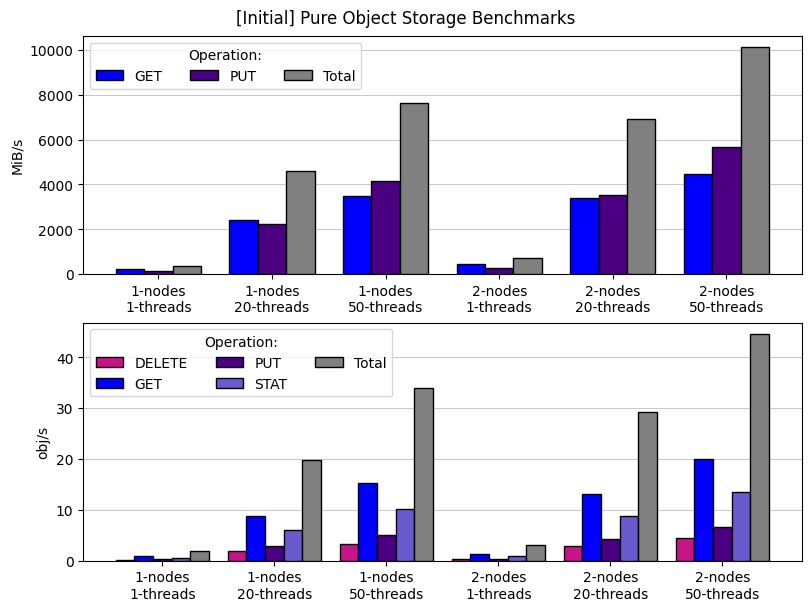

In [222]:
def naive_scores(df):
    df = df.copy()
    df["MiB/s"] = (df.bytes / 1024**2) / (df.duration_ns / 1e9)
    scores = {}
    for op in sorted(df.op.unique()):
        data = df[df.op == op]
        scores[op] = {}
        scores[op]['obj_per_sec'] = data.file.count() / (data.end.max() - data.start.min()).seconds
        if op in ['GET', 'PUT']:
#             scores[op]['MiB_per_sec'] = data.groupby('thread')['MiB/s'].mean().sum()
            scores[op]['MiB_per_sec'] = data['MiB/s'].mean() * len(data.thread.unique())
    
    scores['Total'] = {
        'MiB_per_sec': sum(scores[op]['MiB_per_sec'] for op in ['GET', 'PUT']),
        'obj_per_sec': df.file.count() / (df.end.max() - df.start.min()).seconds,
    }
    return scores
    
scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    df, cmd = load_data(f'benchmark-runs/warp-results-full.mixed-{nodes}-{threads}-1000-1KiB-5GiB-30m.csv.zst')
    scores[key] = naive_scores(df)

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
plt.savefig("initial-pure-results.png")
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_53690/2356893658.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


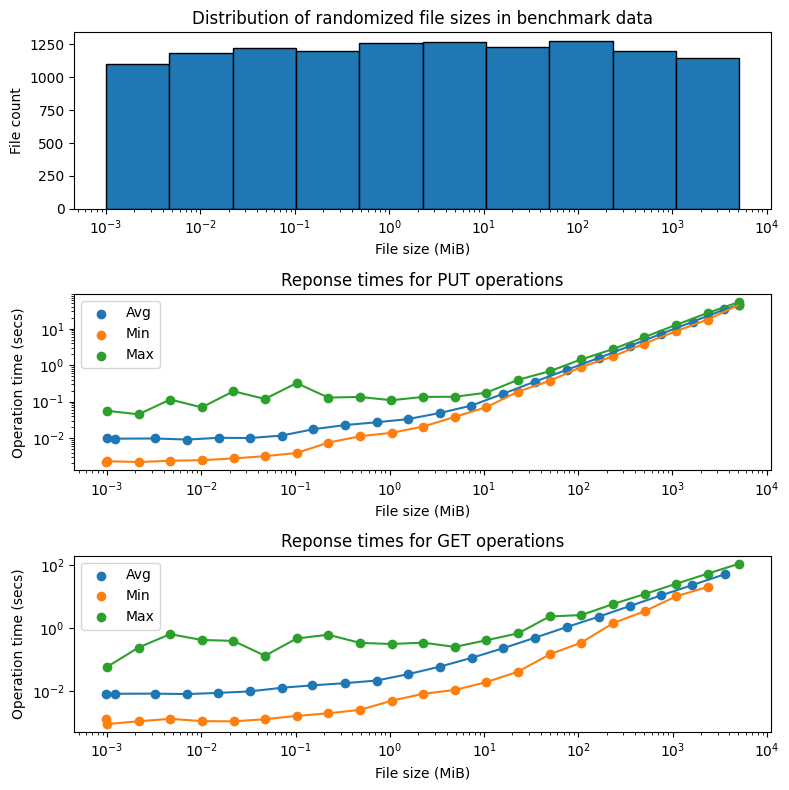

In [4]:
# Create plot 
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
fig, axs = plt.subplots(figsize=(8, 8), nrows=3)
make_filesize_histogram(df, axs[0])
make_timings_plot(df, axs[1], "PUT")
make_timings_plot(df, axs[2], "GET")
plt.tight_layout()
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_17718/1618230849.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, group in data.drop(['thread'], axis=1).groupby(['bytes_bucket']):


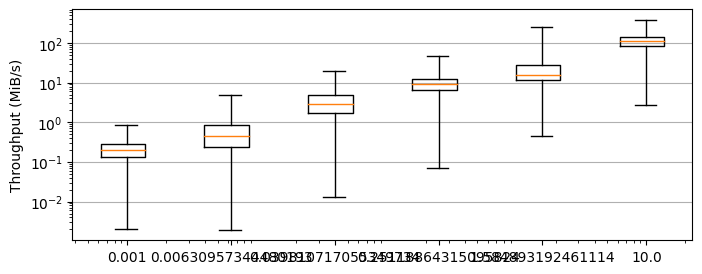

In [241]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xscale('log')
ax.set_ylabel('Throughput (MiB/s)')
ax.set_yscale('log')
ax.grid('on', axis='y')

for i, group in data.drop(['thread'], axis=1).groupby(['bytes_bucket']):
    throughput = (group.bytes / 1024**2) / (group.duration_ns * 1e-9)
    ax.boxplot(throughput, positions=[bins[i]], whis=(0, 100), widths=0.75*bins[i])

# ax.set_xscale('')
# x_labels = data.groupby('bytes_bucket').bytes.max().map(lambda val: round(val / 1024**2, ndigits=3))
# x_labels = data.groupby('bytes_bucket').bytes.max().map(lambda val: f"{val:.3g}")
# ax.set_xticklabels(x_labels, rotation=-45)
plt.show()

In [317]:
df_analyzed = pd.read_csv("results_analyzed.csv", sep="\t")
df_analyzed

,index,op,host,duration_s,objects_per_op,bytes,full_ops,partial_ops,ops_started,ops_ended,errors,mb_per_sec,ops_ended_per_sec,objs_per_sec,reqs_ended_avg_ms,start_time,end_time
0,0,PUT,http://fs-perf-dev-login-0:9000,1,1,348909838,266,39,286,285,0,332.74635124206543,285,289.3893263690584,56.40032255438595,2023-02-15 11:14:42.118062506 +0000 UTC,2023-02-15 11:14:43.118062506 +0000 UTC
1,1,PUT,http://fs-perf-dev-login-0:9000,1,1,402545597,298,40,318,318,0,383.8973970413208,318,313.02223408668135,73.22804761320754,2023-02-15 11:14:43.118062506 +0000 UTC,2023-02-15 11:14:44.118062506 +0000 UTC
2,2,PUT,http://fs-perf-dev-login-0:9000,1,1,352329271,284,40,304,304,0,336.0073766708374,304,310.5934517776044,56.87420175986845,2023-02-15 11:14:44.118062506 +0000 UTC,2023-02-15 11:14:45.118062506 +0000 UTC
3,3,PUT,http://fs-perf-dev-login-0:9000,1,1,266272593,197,40,217,217,0,253.93733310699463,217,209.44104304136007,104.69695640092168,2023-02-15 11:14:45.118062506 +0000 UTC,2023-02-15 11:14:46.118062506 +0000 UTC
4,4,PUT,http://fs-perf-dev-login-0:9000,1,1,383980809,372,40,392,392,0,366.19263553619385,392,393.81238883385896,51.051465545918404,2023-02-15 11:14:46.118062506 +0000 UTC,2023-02-15 11:14:47.118062506 +0000 UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,114,GET,http://fs-perf-dev-login-0:9000,5,1,3863402612,2915,40,2935,2935,0,736.8855690002441,587,587.4560450344351,33.919761693696685,2023-02-15 11:24:22.095808809 +0000 UTC,2023-02-15 11:24:27.095808809 +0000 UTC
122,115,GET,http://fs-perf-dev-login-0:9000,5,1,4174352419,3464,40,3484,3484,0,796.1945379257202,696.8,694.9325438994845,28.537003970723326,2023-02-15 11:24:27.095808809 +0000 UTC,2023-02-15 11:24:32.095808809 +0000 UTC
123,116,GET,http://fs-perf-dev-login-0:9000,5,1,3740417812,3124,40,3144,3144,0,713.4280799865722,628.8,629.9992608420849,32.09282537945292,2023-02-15 11:24:32.095808809 +0000 UTC,2023-02-15 11:24:37.095808809 +0000 UTC
124,117,GET,http://fs-perf-dev-login-0:9000,5,1,3701756801,3212,40,3232,3232,0,706.0540773391724,646.4,647.1346859307301,30.32831833756182,2023-02-15 11:24:37.095808809 +0000 UTC,2023-02-15 11:24:42.095808809 +0000 UTC
